In [54]:
import numpy as np
import pandas as pd
import xarray as xr
import math

import datetime
import glob
import os
import sys
import dask

import scipy
from scipy import stats
import statistics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.pyplot import show
# mpl.rcParams['hatch.linewidth'] = 2.5  # for significant hatching

import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime

from shapely.geometry import Polygon,Point
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import regionmask
import random

import time
from time import time

# reduce warnings (less pink)
import warnings
warnings.filterwarnings('ignore')

print('Loaded Libraries')

Loaded Libraries


In [587]:
variable_list = ['pr','tasmin','tasmax','et','smc','swe']
variable_disp_list = ['Precipitation','Min Temperature', 'Max Temperature', 'Evapotranspiration', 'Soil Moisture Content']
unit_list = ['mm/month', '°C','°C','mm/month', 'mm','mm']
cmap_list = ['bwr_r','Reds','Reds','bwr','bwr_r']
change_vmax_list = [6,6,6,6,20]
change_vmin_list = [-6,0,0,-6,-20]
vmax_list = [150,20,33,110,500]
vmin_list = [100,8,20,40,100]
ds_dict = {}
for var in variable_list:
    ds_dict[var] = xr.open_mfdataset(f'hydro5/Extraction_{var}.nc')
    ds_dict[var] = ds_dict[var].mean(dim = 'projection')


In [9]:
ds_dict[var].dims

Frozen({'time': 1440, 'latitude': 93, 'longitude': 133})

In [10]:
min_lat, max_lat = np.min(ds_dict['pr'].latitude.values), np.max(ds_dict['pr'].latitude.values)
min_lon, max_lon = np.min(ds_dict['pr'].longitude.values), np.max(ds_dict['pr'].longitude.values)
print(min_lat, max_lat)
print(min_lon, max_lon)

30.4375 41.9375
-124.5625 -108.0625


In [13]:
pinyon_obs = pd.read_csv('observations-266903.csv')
# pinyon_obs
pinyon_obs['year'] = [i.year for i in pd.to_datetime(pinyon_obs['observed_on'])]
pinyon_obs = pinyon_obs[pinyon_obs['year'] >= 1990]                                                             
pinyon_obs = pinyon_obs[(pinyon_obs['longitude'] >= min_lon) & (pinyon_obs['longitude'] <= max_lon)]
pinyon_obs = pinyon_obs[(pinyon_obs['latitude'] >= min_lat) & (pinyon_obs['latitude'] <= max_lat)]
pinyon_obs = pinyon_obs.reset_index()

pinyon_obs = pinyon_obs.drop('index', axis = 1)
pinyon_obs[['latitude','longitude','observed_on','scientific_name']]


,latitude,longitude,observed_on,scientific_name
0,35.668627,-118.036367,5/29/11,Pinus monophylla
1,34.026291,-116.147003,8/4/11,Pinus monophylla
2,34.414096,-117.856607,4/4/05,Pinus monophylla
3,38.007059,-119.012259,9/21/12,Pinus monophylla
4,34.033882,-116.135490,10/26/12,Pinus monophylla
...,...,...,...,...
4799,40.378178,-114.832345,10/13/22,Pinus monophylla
4800,40.308830,-114.884138,10/14/22,Pinus monophylla
4801,40.144542,-115.153747,10/15/22,Pinus monophylla
4802,40.249092,-114.983697,10/15/22,Pinus monophylla


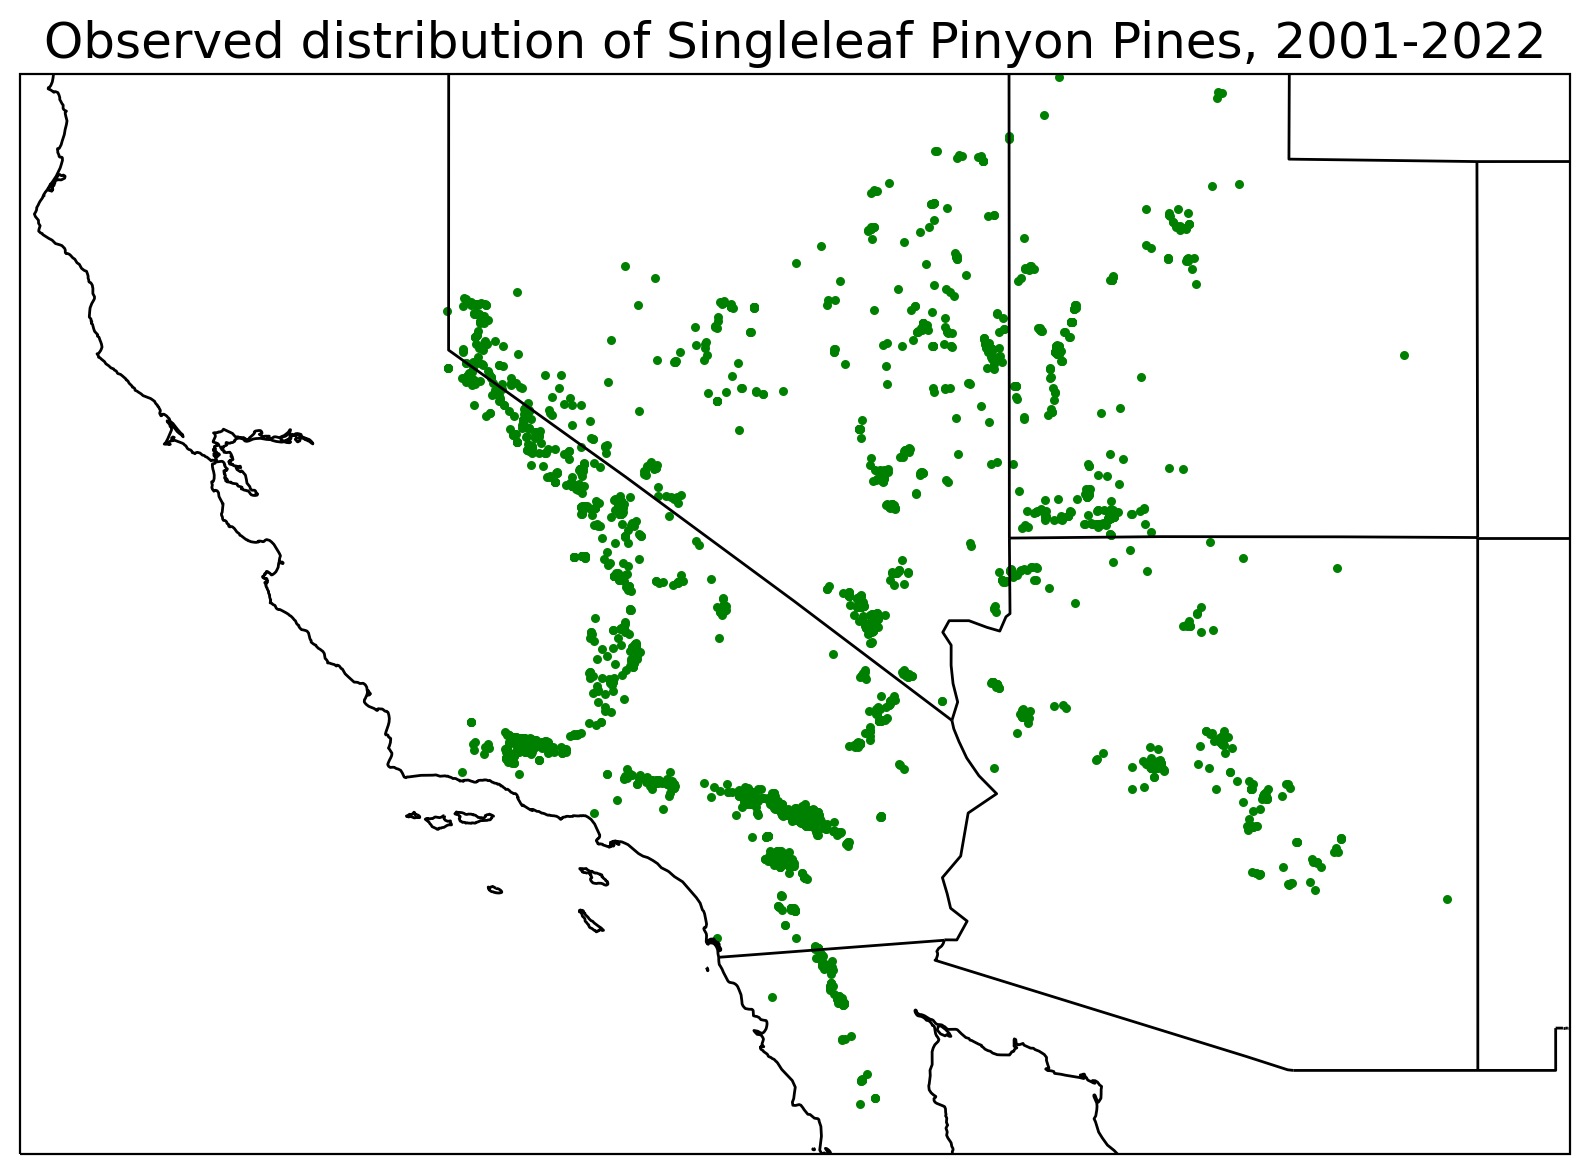

In [14]:
fig,ax=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10), dpi = 200,subplot_kw={'projection':ccrs.PlateCarree()})

plt.scatter(pinyon_obs['longitude'], pinyon_obs['latitude'],s = 5, c='green')

ax.set_title('Observed distribution of {}, 2001-2022'.format('Singleleaf Pinyon Pines'), fontsize = 18)

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.coastlines(linewidth=1)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                            name='admin_1_states_provinces_lines',
                            scale='110m',facecolor='None'),edgecolor='k')


In [558]:
%%time
pinyon_grid_presence = np.zeros((len(ds_dict['pr'].latitude), len(ds_dict['pr'].longitude)))
for row in range(pinyon_grid_presence.shape[0]):
    print(row)
    for col in range(pinyon_grid_presence.shape[1]):
        if (row < pinyon_grid_presence.shape[0]-1) and (col < pinyon_grid_presence.shape[1]-1):
            grid_lat = [ds_dict['pr'].latitude.values[row], ds_dict['pr'].latitude.values[row+1]]
            grid_lon = [ds_dict['pr'].longitude.values[col], ds_dict['pr'].longitude.values[col+1]]
        for obs in range(len(pinyon_obs)):
            if (pinyon_obs.loc[obs,'latitude'] >= grid_lat[0]) and (pinyon_obs.loc[obs,'latitude'] < grid_lat[1]):
                if (pinyon_obs.loc[obs,'longitude'] >= grid_lon[0]) and (pinyon_obs.loc[obs,'longitude'] < grid_lon[1]):
                    pinyon_grid_presence[row,col] = 1
                    break
pinyon_grid_presence = xr.where((pinyon_grid_presence + xr.where(mask >= 0, 1, 0))>0, 1, 0).values


CPU times: user 5.76 ms, sys: 2.59 ms, total: 8.34 ms
Wall time: 9.56 ms


In [559]:
%%time
pinyon_grid_pseudo_absence = np.zeros((len(ds_dict['pr'].latitude), len(ds_dict['pr'].longitude)))

num_of_presence = len(pinyon_grid_presence[pinyon_grid_presence == 1])

for row in range(pinyon_grid_pseudo_absence.shape[0]):
    for col in range(pinyon_grid_pseudo_absence.shape[1]):
        if pinyon_grid_presence[row,col] == 0:
            rand = random.random()
            if rand <= 2*num_of_presence/(len(ds_dict['pr'].longitude) * len(ds_dict['pr'].latitude) - num_of_presence):
                pinyon_grid_pseudo_absence[row,col] = 0.5
                
pinyon_grid_presence_and_pseudo_absence = pinyon_grid_presence + pinyon_grid_pseudo_absence

pinyon_grid_pseudo_absence.mean()


CPU times: user 273 ms, sys: 1.89 ms, total: 275 ms
Wall time: 276 ms


0.07215619694397284

In [29]:
historical = {}
mid_century = {}
end_of_century = {}

time_horizon_list = ['historical', 'mid_century', 'end_of_century']
time_horizon_start_year_list = [1994, 2035, 2070]
time_horizon_end_year_list = [2023, 2064, 2099]

i = 0
for time_horizon in time_horizon_list:
    for var in variable_list:
        eval(time_horizon)[var] = ds_dict[var].sel(time=slice(f'{time_horizon_start_year_list[i]}-01-01',f'{time_horizon_end_year_list[i]}-12-31')).mean(dim = 'time')
    i += 1
historical[var]

<xarray.Dataset>
Dimensions:    (latitude: 93, longitude: 133)
Coordinates:
  * latitude   (latitude) float32 30.44 30.56 30.69 30.81 ... 41.69 41.81 41.94
  * longitude  (longitude) float32 -124.6 -124.4 -124.3 ... -108.3 -108.2 -108.1
Data variables:
    swe        (latitude, longitude) float32 dask.array<chunksize=(93, 133), meta=np.ndarray>

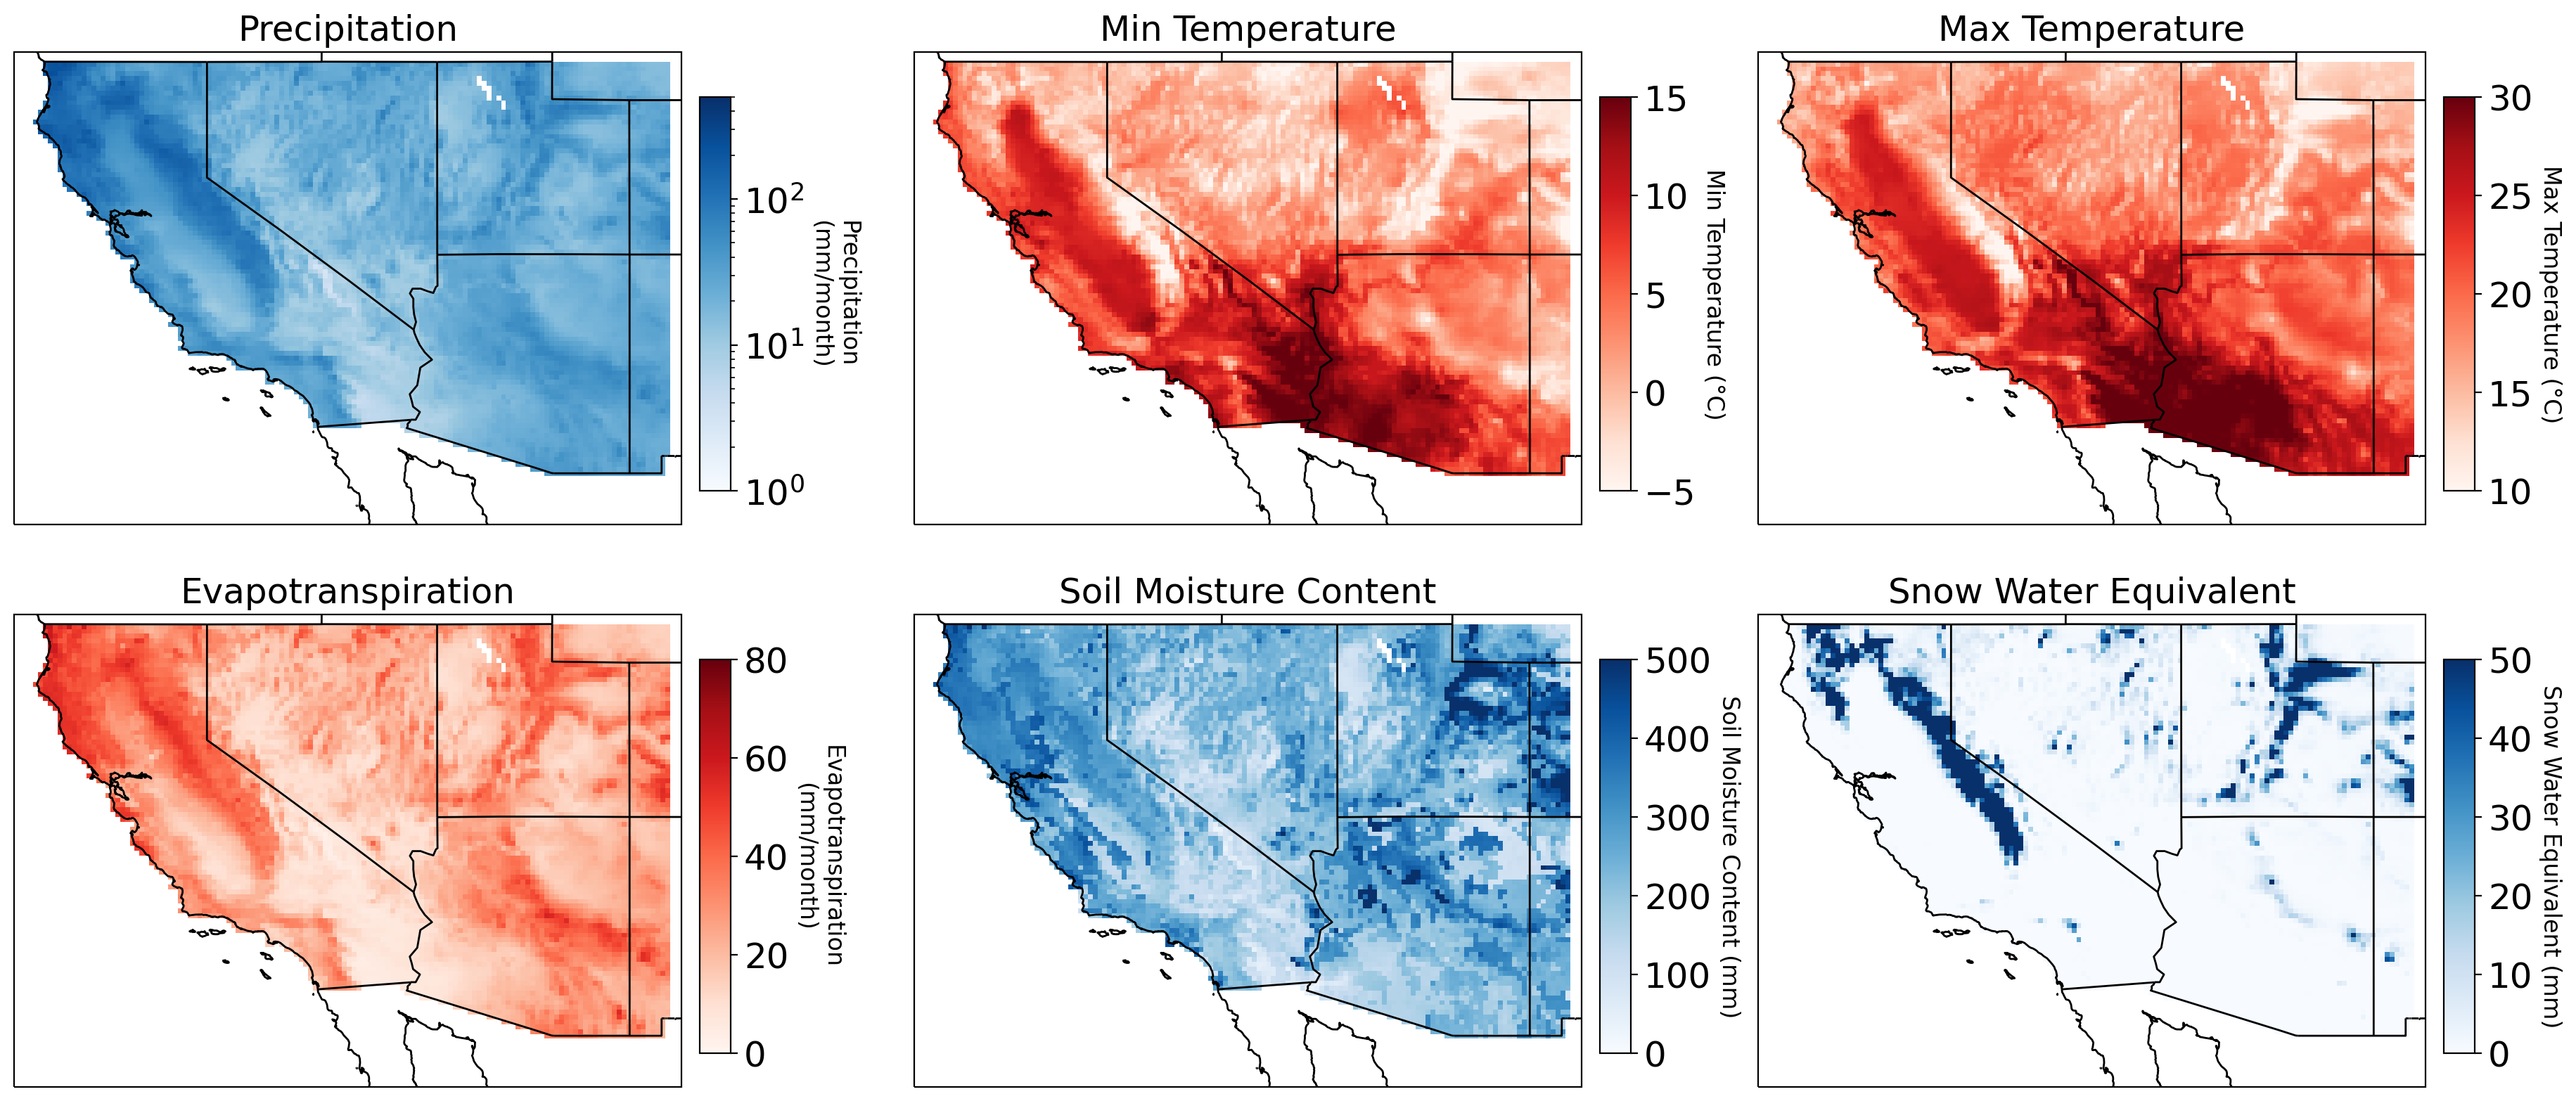

In [615]:
fig,ax=plt.subplots(2,3,sharex = True, sharey = True,figsize=(20,8), dpi = 200,subplot_kw={'projection':ccrs.PlateCarree()})
# var_ds = dict_of_daily_obs_vars[f'SNEQV'].resample(day='A-AUG').max(dim = 'day').mean(dim = 'day').load()
# var_ds

bounds = [0,0.9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2)
cmap_presence = (colors.ListedColormap(['white','lightgreen']))

vmax_list = [500,15,30,80,500,50]
vmin_list = [1,-5,10,0,0,0]
variable_list = ['pr','tasmin','tasmax','et','smc','swe']
variable_disp_list = ['Precipitation','Min Temperature', 'Max Temperature', 'Evapotranspiration', 'Soil Moisture Content','Snow Water Equivalent']
unit_list = ['mm/month', '°C', '°C', 'mm/month', 'mm', 'mm']
cmap_list = ['Blues','Reds','Reds','Reds','Blues','Blues']
i = 0
for var in variable_list:
    row = i // 3
    col = i % 3

    if var == 'pr':
        plot = ax[row,col].pcolormesh(ds_dict[var].longitude, ds_dict[var].latitude, ds_dict[var].sel(time = slice('1990-10-01','2022-09-30')).mean(dim = 'time')[var], transform=ccrs.PlateCarree(),
                          cmap = cmap_list[i], 
                          norm = colors.LogNorm(vmin=vmin_list[i], vmax=vmax_list[i]))
    else:
        plot = ax[row,col].pcolormesh(ds_dict[var].longitude, ds_dict[var].latitude, ds_dict[var].sel(time = slice('1990-10-01','2022-09-30')).mean(dim = 'time')[var], transform=ccrs.PlateCarree(),
                          cmap = cmap_list[i], 
                          vmax = vmax_list[i], vmin = vmin_list[i])
    if col == 0:
        ax[row,col].set_position([0.08,(1-row)*0.5,0.25,0.42]);
    else:
        ax[row,col].set_position([col*0.3+0.1,(1-row)*0.5,0.25,0.42]);
    
    
    if len(unit_list[i]) > 5:
        cbar = fig.colorbar(plot, ax=ax[row,col], shrink=0.75, cax = fig.add_axes([0.08+(col+1)*0.3-0.05,(1-row)*0.5+0.03,0.011,0.35]))
        cbar.set_label(label=f'{variable_disp_list[i]}\n({unit_list[i]})',fontsize=12,labelpad=28, rotation = 270)
    else:
        cbar = fig.colorbar(plot, ax=ax[row,col], shrink=0.75, cax = fig.add_axes([0.1+(col+1)*0.3-0.05,(1-row)*0.5+0.03,0.011,0.35]))
        cbar.set_label(label=f'{variable_disp_list[i]} ({unit_list[i]})',fontsize=12,labelpad=15, rotation = 270)
    cbar.ax.tick_params(labelsize=18) 
    ax[row,col].set_title(f'{variable_disp_list[i]}',fontsize=18)
    i += 1

for i in range(len(variable_list)):
    row = i // 3
    col = i % 3
    
    ax[row,col].set_ylim([30,42.25]);
    ax[row,col].set_xlim([-125,-107.7])
    ax[row,col].coastlines(linewidth=1)
    ax[row,col].add_feature(cfeature.BORDERS)
    ax[row,col].add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='110m',facecolor='None'),edgecolor='k')

    
# ax[i].set_title('Observed distribution of {}, 2001-2022'.format('American Sweetgum'), fontsize = 18)
# plt.tight_layout()

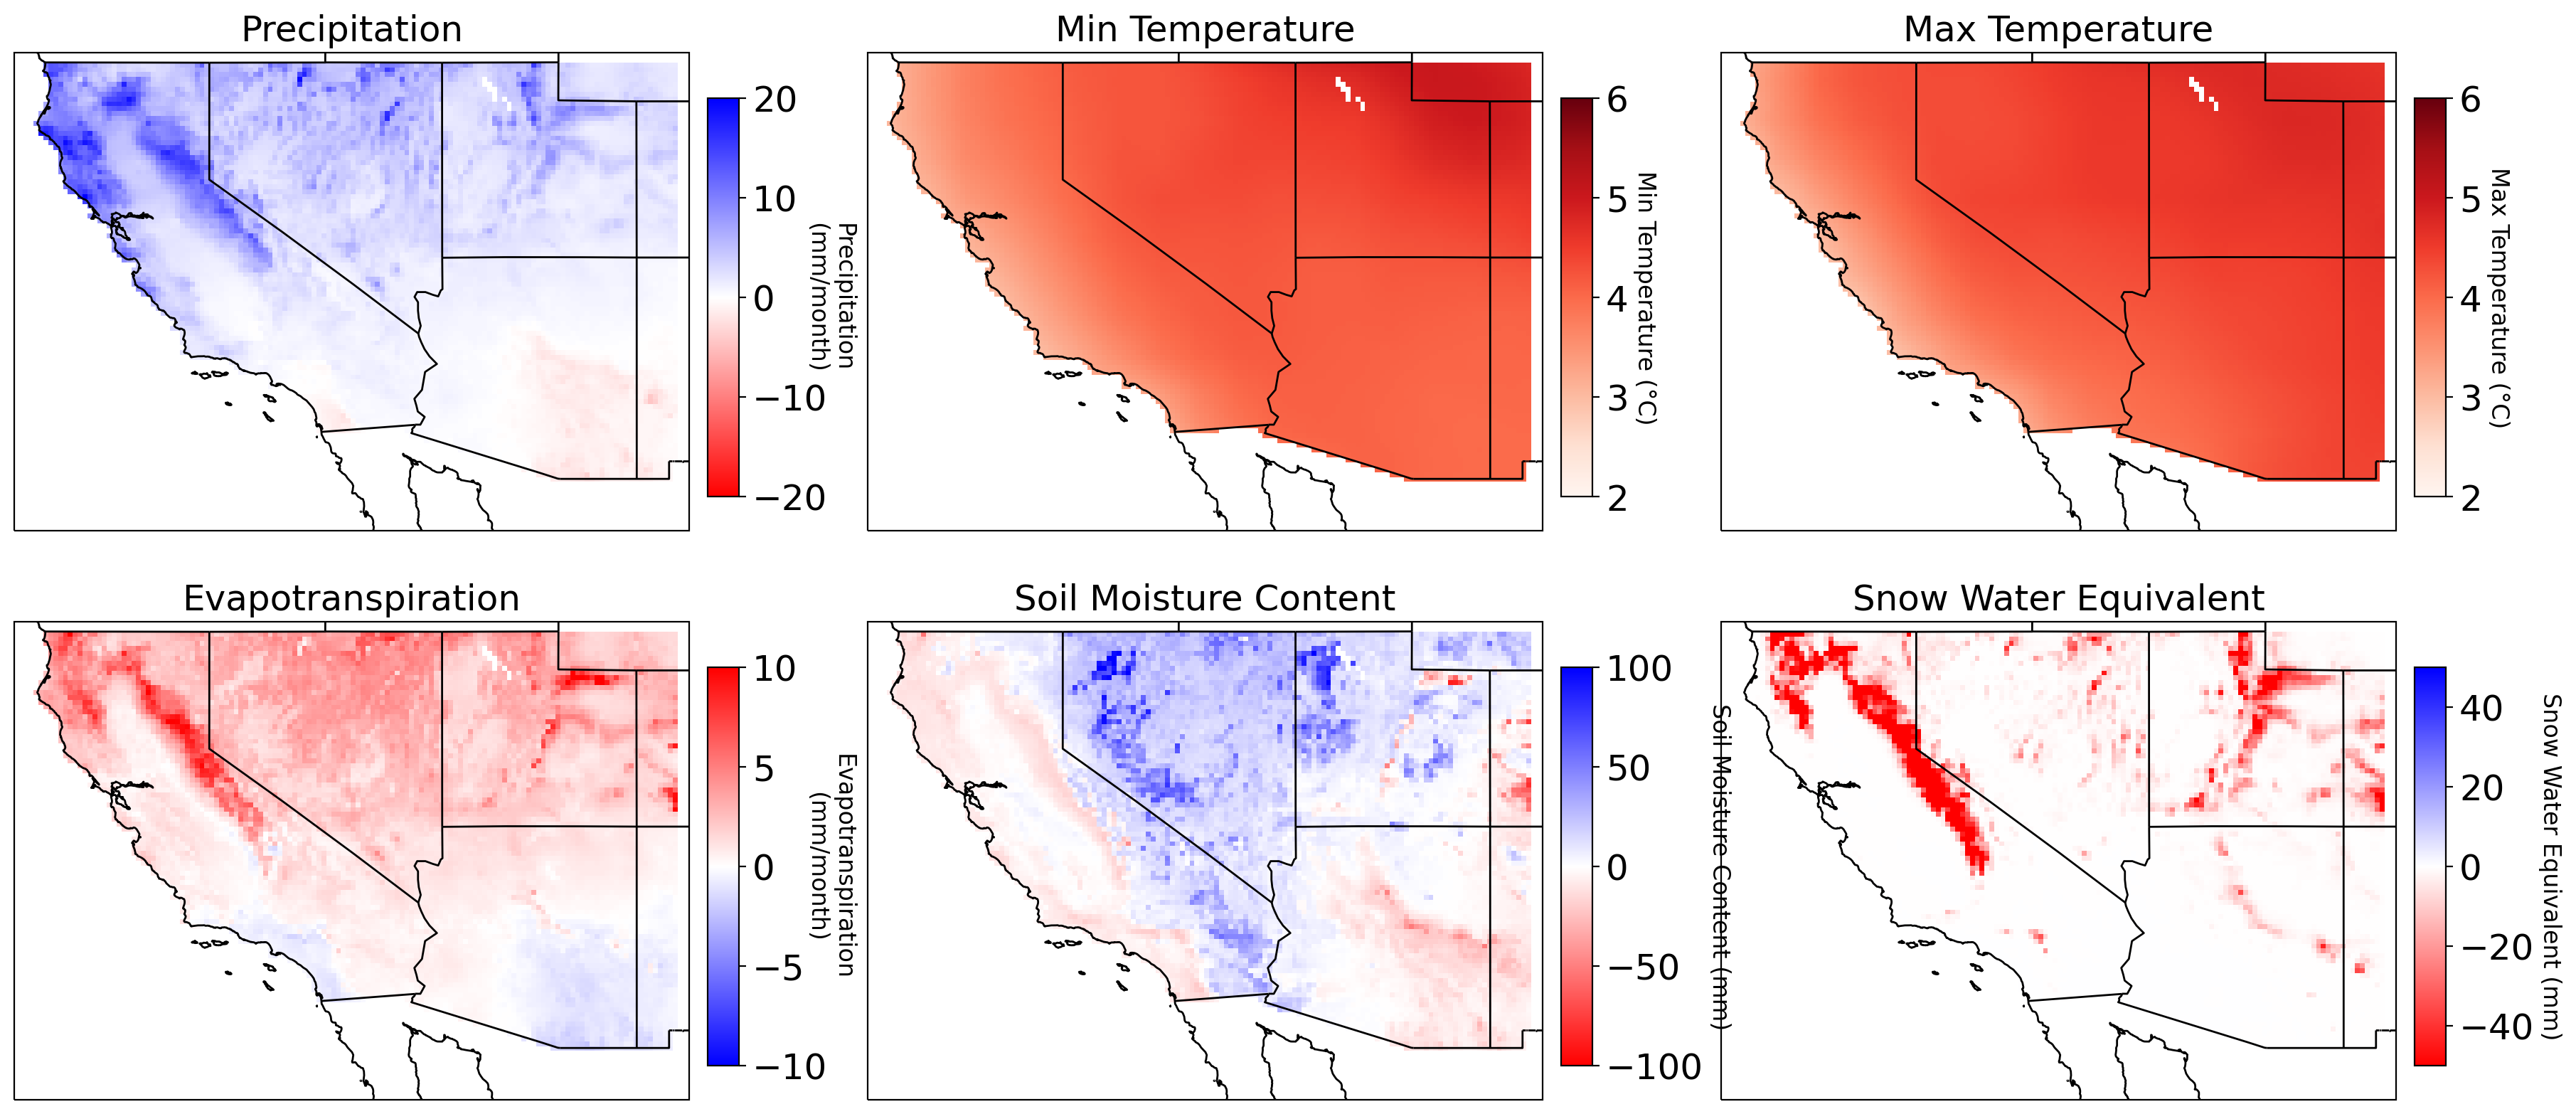

In [616]:
fig,ax=plt.subplots(2,3,sharex = True, sharey = True,figsize=(20,8), dpi = 200,subplot_kw={'projection':ccrs.PlateCarree()})
# var_ds = dict_of_daily_obs_vars[f'SNEQV'].resample(day='A-AUG').max(dim = 'day').mean(dim = 'day').load()
# var_ds

bounds = [0,0.9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2)
cmap_presence = (colors.ListedColormap(['white','lightgreen']))

vmax_list = [20,6,6,10,100,50]
vmin_list = [-20,2,2,-10,-100,-50]
variable_list = ['pr','tasmin','tasmax','et','smc','swe']
unit_list = ['mm/month', '°C', '°C', 'mm/month', 'mm', 'mm']
cmap_list = ['bwr_r','Reds','Reds','bwr','bwr_r','bwr_r']
i = 0
for var in variable_list:
    row = i // 3
    col = i % 3
#     plot = ds_dict[var].sel(time = slice('1990-10-01','2022-09-30')).mean(dim = 'time')[var].plot.pcolormesh(ax = ax[row,col], transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=False, 
#                                                                                                              cmap = cmap_list[i], vmax = vmax_list[i], vmin = vmin_list[i])
    plot = ax[row,col].pcolormesh(ds_dict[var].longitude, ds_dict[var].latitude, ds_dict[var].sel(time = slice('2070-10-01','2100-09-30')).mean(dim = 'time')[var] - ds_dict[var].sel(time = slice('1990-10-01','2022-09-30')).mean(dim = 'time')[var], transform=ccrs.PlateCarree(),
                          cmap = cmap_list[i], 
                          vmax = vmax_list[i], vmin = vmin_list[i])

    ax[row,col].set_position([col*0.3+0.1,(1-row)*0.5,0.25,0.42]);
    
    cbar = fig.colorbar(plot, ax=ax[row,col], shrink=0.75, cax = fig.add_axes([0.1+(col+1)*0.3-0.05,(1-row)*0.5+0.03,0.011,0.35]))
    if len(unit_list[i]) > 5:
        cbar.set_label(label=f'{variable_disp_list[i]}\n({unit_list[i]})',fontsize=12,labelpad=14, rotation = 270)
    else:
        cbar.set_label(label=f'{variable_disp_list[i]} ({unit_list[i]})',fontsize=12,labelpad=14, rotation = 270)
    cbar.ax.tick_params(labelsize=18) 
    ax[row,col].set_title(f'{variable_disp_list[i]}',fontsize=18)
    i += 1

for i in range(len(variable_list)):
    row = i // 3
    col = i % 3
    
    ax[row,col].set_ylim([30,42.25]);
    ax[row,col].set_xlim([-125,-107.7])
    ax[row,col].coastlines(linewidth=1)
    ax[row,col].add_feature(cfeature.BORDERS)
    ax[row,col].add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lines',
                                scale='110m',facecolor='None'),edgecolor='k')

    
# ax[i].set_title('Observed distribution of {}, 2001-2022'.format('American Sweetgum'), fontsize = 18)
# plt.tight_layout()


In [560]:
# X = np.array(variable_ds.prec.sel(time=slice('2014-01-01','2022-12-31')).mean(dim = 'time'))[presence_and_pseudo_absence > 0].reshape(-1, 1)
y = pinyon_grid_presence_and_pseudo_absence[pinyon_grid_presence_and_pseudo_absence > 0].reshape(1, -1)

pr = np.array(historical['pr'].pr.values)[pinyon_grid_presence_and_pseudo_absence > 0]
tasmin = np.array(historical['tasmin'].tasmin.values)[pinyon_grid_presence_and_pseudo_absence > 0]
tasmax = np.array(historical['tasmax'].tasmax.values)[pinyon_grid_presence_and_pseudo_absence > 0]
smc = np.array(historical['smc'].smc.values)[pinyon_grid_presence_and_pseudo_absence > 0]
et = np.array(historical['et'].et.values)[pinyon_grid_presence_and_pseudo_absence > 0]
swe = np.array(historical['swe'].swe.values)[pinyon_grid_presence_and_pseudo_absence > 0]

X = pd.DataFrame(data = {'pr':pr, 'tmin':tasmin, 'tmax':tasmax, 'et': et, 'smc': smc, 'y': y[0]}).dropna()
#
# X = pd.DataFrame(data = {'prcp':prcp, 'tmax':tmax, 'tmin':tmin})
# .reshape(-1, 1)

y = np.array(X['y']).reshape(-1,1)
for i in range(len(y)):
    if y[i] == 0.5:
        y[i] = 0

X = np.array(X.drop('y', axis = 1))
X.shape

(2141, 5)

In [561]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [612]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1000)

pipe = Pipeline([('scaler', StandardScaler()), ('lr', MLPClassifier(hidden_layer_sizes = [20,20], random_state=1000))])

pipe.fit(X_train, y_train)

cv = ShuffleSplit(n_splits=20, test_size=test_size, random_state=1000)
cross_val_score(pipe, X, y, cv=cv, scoring = 'f1').mean()


0.6234302394280675

In [613]:
# # clf = GradientBoostingClassifier(min_samples_split = 60, min_samples_leaf = 3, max_depth= 3, n_estimators = 150, warm_start= True, random_state=1000)
# clf = GradientBoostingClassifier(min_samples_split = 60, min_samples_leaf = 3, max_depth= 3, n_estimators = 150, warm_start= True, random_state=1000)
# clf.fit(X,y)

pipe = Pipeline([('scaler', StandardScaler()), ('lr', MLPClassifier(hidden_layer_sizes = [20,20], random_state=1000))])
pipe.fit(X,y)
clf = pipe

time_horizon_disp_list = ['Historical Period', 'Mid Century', 'End of Century']

for time_horizon in ['historical', 'mid_century', 'end_of_century']:
    print(time_horizon)
# time_horizon = 'end_of_century' #### 'historical', 'mid_century', 'end_of_century'
    time_horizon_disp = time_horizon_disp_list[time_horizon_list.index(time_horizon)]

    pr_test = np.array(eval(time_horizon)['pr'].pr.values).reshape(1,-1)
    tasmin_test = np.array(eval(time_horizon)['tasmin'].tasmin.values).reshape(1,-1)
    tasmax_test = np.array(eval(time_horizon)['tasmax'].tasmax.values).reshape(1,-1)
    smc_test = np.array(eval(time_horizon)['smc'].smc.values).reshape(1,-1)
    et_test = np.array(eval(time_horizon)['et'].et.values).reshape(1,-1)
    swe_test = np.array(eval(time_horizon)['swe'].swe.values).reshape(1,-1)

    X_test = pd.DataFrame(data = {'pr':pr_test[0],'tasmin': tasmin_test[0], 'tasmax':tasmax_test[0],'et':et_test[0], 'smc': smc_test[0]}).fillna(-9999999)

    Y_pred_proba, Y_pred = clf.predict_proba(X_test)[:,1].reshape(len(ds_dict['pr'].latitude), len(ds_dict['pr'].longitude)), clf.predict(X_test).reshape(len(ds_dict['pr'].latitude), len(ds_dict['pr'].longitude))


    eval(time_horizon)['pr'] = eval(time_horizon)['pr'].assign({'Y_pred':(['latitude','longitude'],Y_pred),
                                              'Y_pred_proba':(['latitude','longitude'],Y_pred_proba)})

    print(f'By probablity: {Y_pred_proba.mean()}')
    print(f'By area: {Y_pred.mean()}')


historical
By probablity: 0.24826548993587494
By area: 0.19476109628910987
mid_century
By probablity: 0.21872927248477936
By area: 0.1490015360983103
end_of_century
By probablity: 0.1951410174369812
By area: 0.12054329371816638


In [607]:
historical['pr'] = historical['pr'].assign({'observation':(['latitude','longitude'],pinyon_grid_presence)})

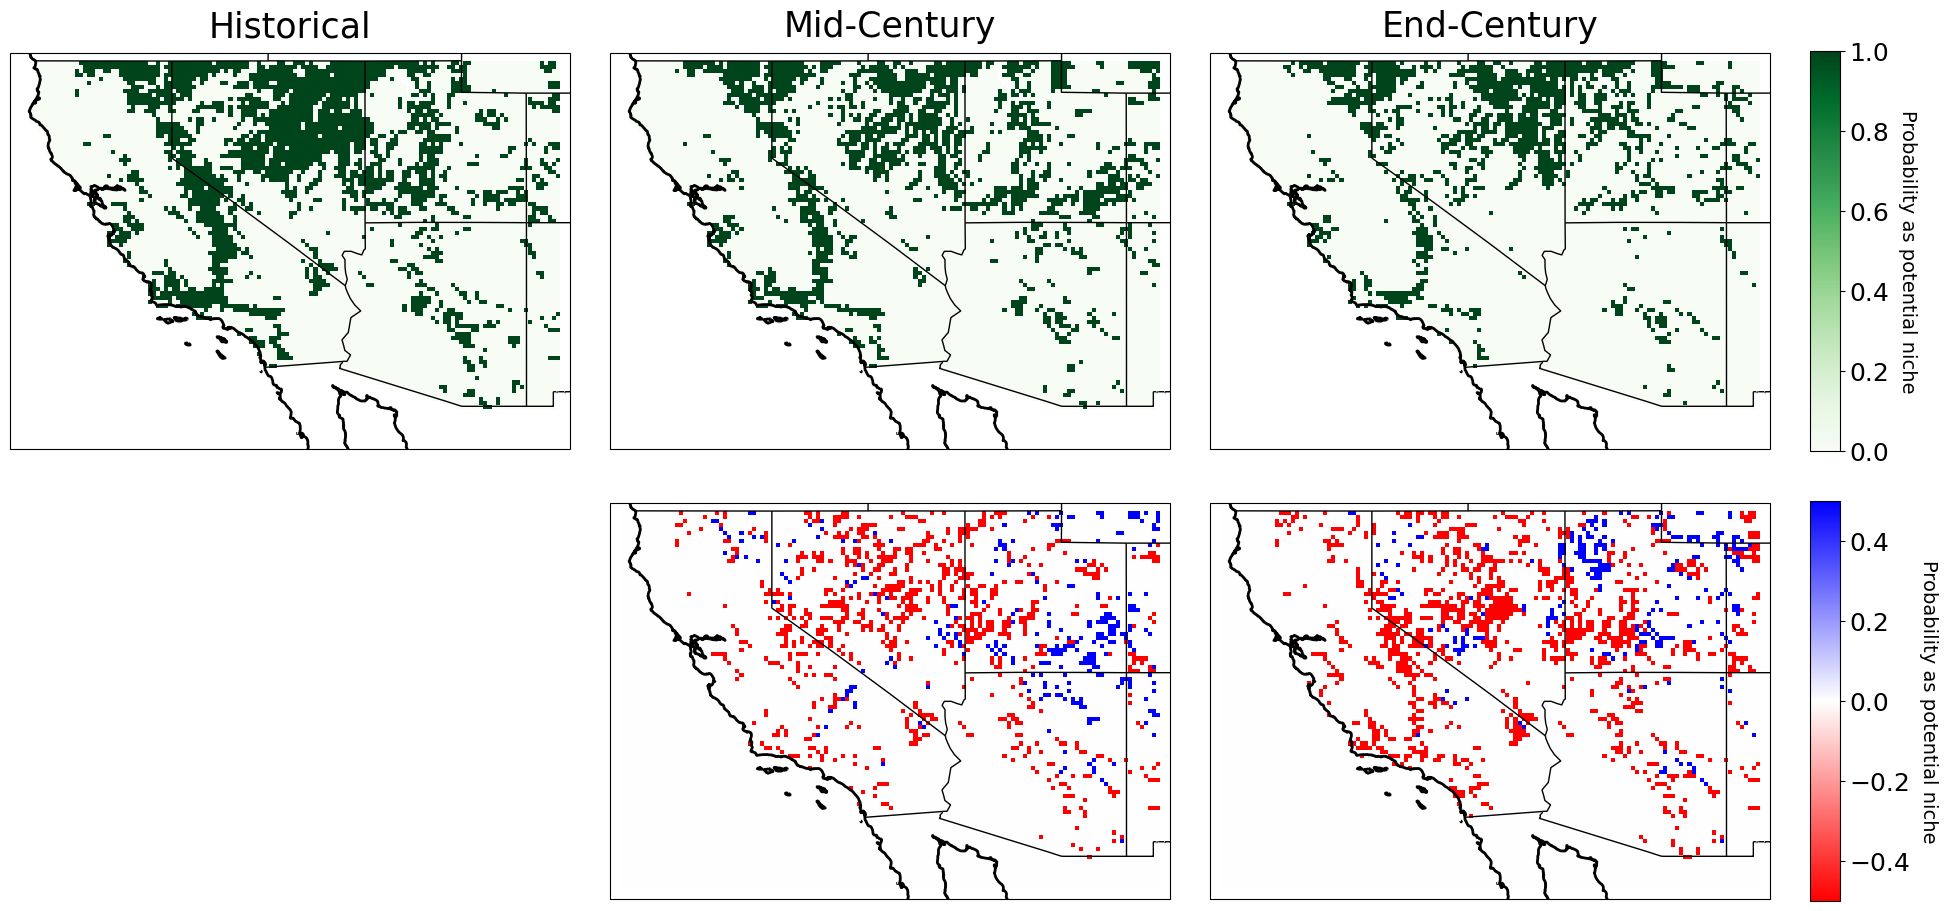

In [609]:
fig,ax=plt.subplots(2,3,sharex=True,sharey=True,figsize=(20,10), dpi = 100,subplot_kw={'projection':ccrs.PlateCarree()})

bounds = [0,0.9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2)
cmap_presence = (colors.ListedColormap(['white','lightgreen']))

pred_type = 'Y_pred'

p1 = ax[0,0].pcolormesh(historical['pr'].longitude,historical['pr'].latitude, xr.where(historical['pr']['pr'] > -1, historical['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')
p1 = ax[0,1].pcolormesh(mid_century['pr'].longitude,mid_century['pr'].latitude, xr.where(mid_century['pr']['pr'] > -1, mid_century['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')
p1 = ax[0,2].pcolormesh(end_of_century['pr'].longitude,end_of_century['pr'].latitude, xr.where(end_of_century['pr']['pr'] > -1, end_of_century['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')

(mid_century['pr'][pred_type] - historical['pr'][pred_type]).plot.pcolormesh(ax = ax[1,1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=False, vmin =-0.5, vmax = 0.5, cmap = 'bwr_r')
p2 = (end_of_century['pr'][pred_type] - historical['pr'][pred_type]).plot.pcolormesh(ax = ax[1,2], transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=False, vmin =-0.5, vmax = 0.5, cmap = 'bwr_r')

cbar = fig.colorbar(p1, ax=ax[0,2], shrink=0.5, cax = fig.add_axes([1,0.48,0.015,0.4]))
cbar.set_label(label='Probability as potential niche',fontsize=14,labelpad=20,rotation = 270)
cbar.ax.tick_params(labelsize=18) 

cbar2 = fig.colorbar(p2, ax=ax[1,2], shrink=0.5, cax = fig.add_axes([1,0.03,0.015,0.4]))
cbar2.set_label(label='Probability as potential niche',fontsize=14,labelpad=20,rotation = 270)
cbar2.ax.tick_params(labelsize=18) 

ax[0,0].set_title('Historical',fontsize = 25,y = 1.02)
ax[0,1].set_title('Mid-Century',fontsize = 25,y = 1.02)
ax[0,2].set_title('End-Century',fontsize = 25,y = 1.02)

for col in range(3):  
    for row in range(2):
        ax[row,col].set_ylim([30,42.25]);
        ax[row,col].set_xlim([-125,-107.7])
        ax[row,col].set_position([col*0.3+0.1,(1-row)*0.45,0.28,0.46]);
        ax[row,col].coastlines(linewidth=2)
        ax[row,col].add_feature(cfeature.BORDERS)
        ax[row,col].add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),edgecolor='k')

fig.delaxes(ax[1,0])


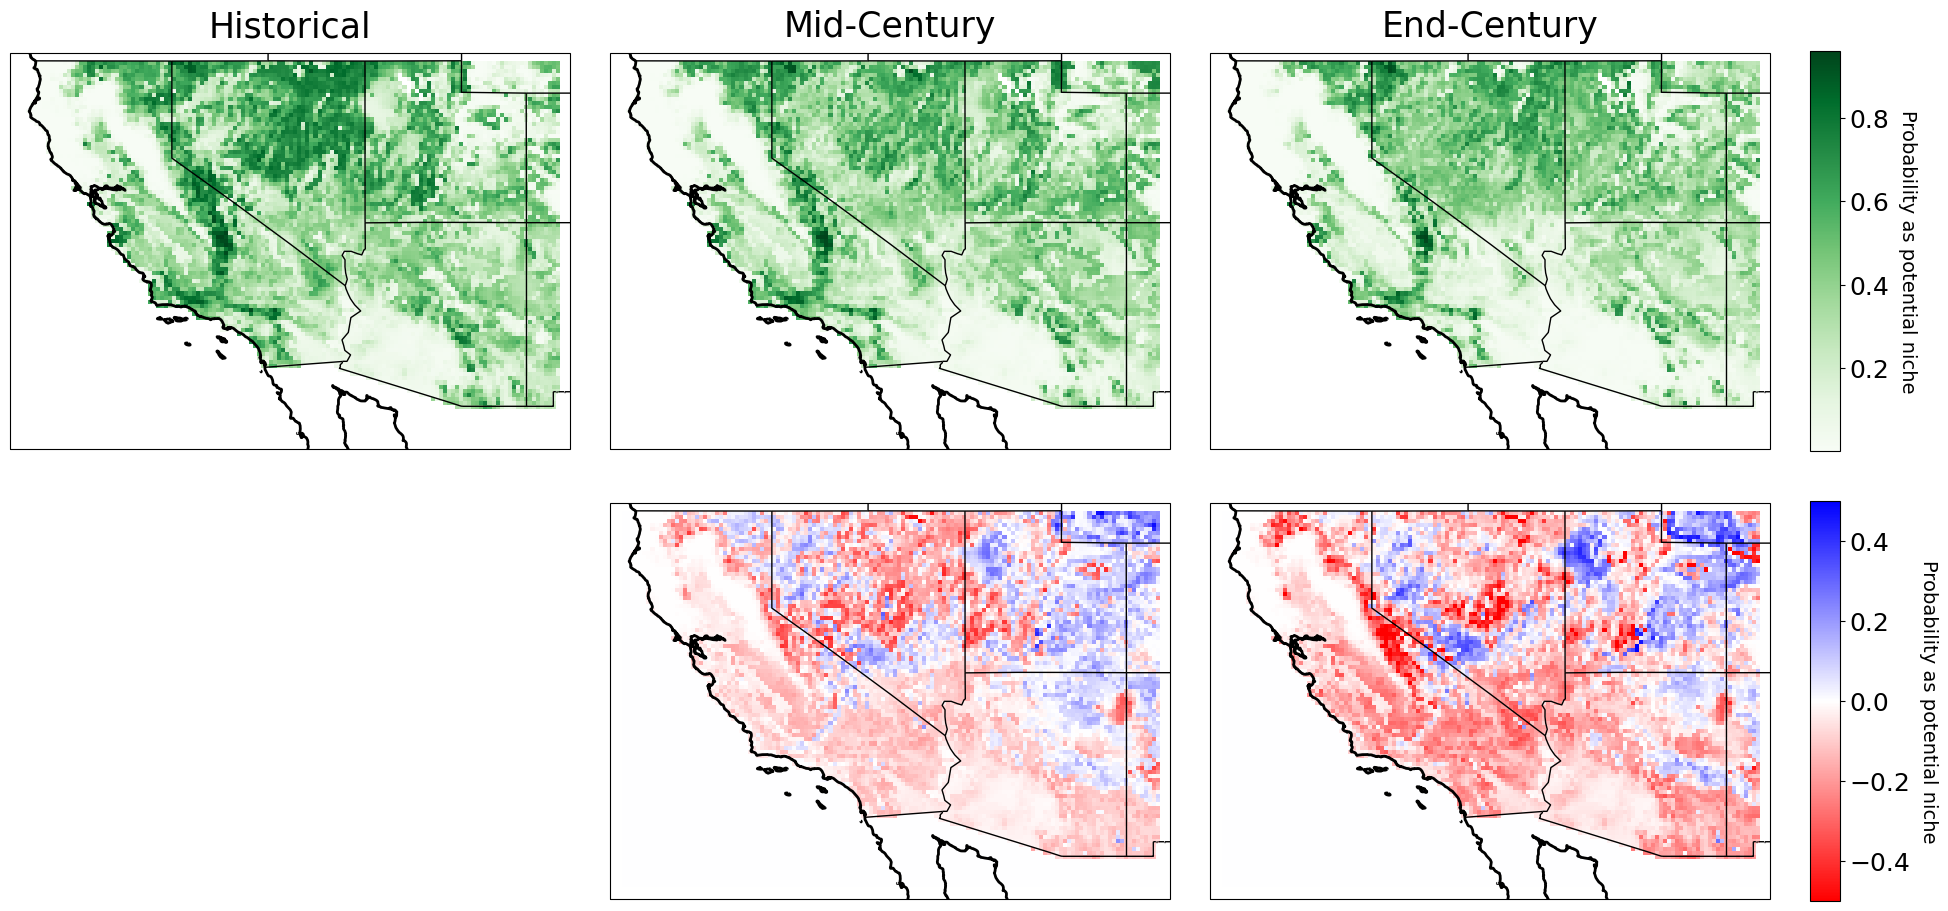

In [608]:
fig,ax=plt.subplots(2,3,sharex=True,sharey=True,figsize=(20,10), dpi = 100,subplot_kw={'projection':ccrs.PlateCarree()})
# var_ds = dict_of_daily_obs_vars[f'SNEQV'].resample(day='A-AUG').max(dim = 'day').mean(dim = 'day').load()
# var_ds

bounds = [0,0.9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2)
cmap_presence = (colors.ListedColormap(['white','lightgreen']))

pred_type = 'Y_pred_proba'

p1 = ax[0,0].pcolormesh(historical['pr'].longitude,historical['pr'].latitude, xr.where(historical['pr']['pr'] > -1, historical['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')
p1 = ax[0,1].pcolormesh(mid_century['pr'].longitude,mid_century['pr'].latitude, xr.where(mid_century['pr']['pr'] > -1, mid_century['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')
p1 = ax[0,2].pcolormesh(end_of_century['pr'].longitude,end_of_century['pr'].latitude, xr.where(end_of_century['pr']['pr'] > -1, end_of_century['pr'][pred_type], np.nan), transform=ccrs.PlateCarree(),cmap = 'Greens')

(mid_century['pr'][pred_type] - historical['pr'][pred_type]).plot.pcolormesh(ax = ax[1,1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=False, vmin =-0.5, vmax = 0.5, cmap = 'bwr_r')
p2 = (end_of_century['pr'][pred_type] - historical['pr'][pred_type]).plot.pcolormesh(ax = ax[1,2], transform=ccrs.PlateCarree(), x='longitude', y='latitude', add_colorbar=False, vmin =-0.5, vmax = 0.5, cmap = 'bwr_r')

cbar = fig.colorbar(p1, ax=ax[0,2], shrink=0.5, cax = fig.add_axes([1,0.48,0.015,0.4]))
cbar.set_label(label='Probability as potential niche',fontsize=14,labelpad=20,rotation = 270)
cbar.ax.tick_params(labelsize=18) 

cbar2 = fig.colorbar(p2, ax=ax[1,2], shrink=0.5, cax = fig.add_axes([1,0.03,0.015,0.4]))
cbar2.set_label(label='Probability as potential niche',fontsize=14,labelpad=20,rotation = 270)
cbar2.ax.tick_params(labelsize=18) 

ax[0,0].set_title('Historical',fontsize = 25,y = 1.02)
ax[0,1].set_title('Mid-Century',fontsize = 25,y = 1.02)
ax[0,2].set_title('End-Century',fontsize = 25,y = 1.02)

for col in range(3):
    for row in range(2):
        ax[row,col].set_ylim([30,42.25]);
        ax[row,col].set_xlim([-125,-107.7])
        ax[row,col].set_position([col*0.3+0.1,(1-row)*0.45,0.28,0.46]);
        ax[row,col].coastlines(linewidth=2)
        ax[row,col].add_feature(cfeature.BORDERS)
        ax[row,col].add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='110m',facecolor='None'),edgecolor='k')

fig.delaxes(ax[1,0])


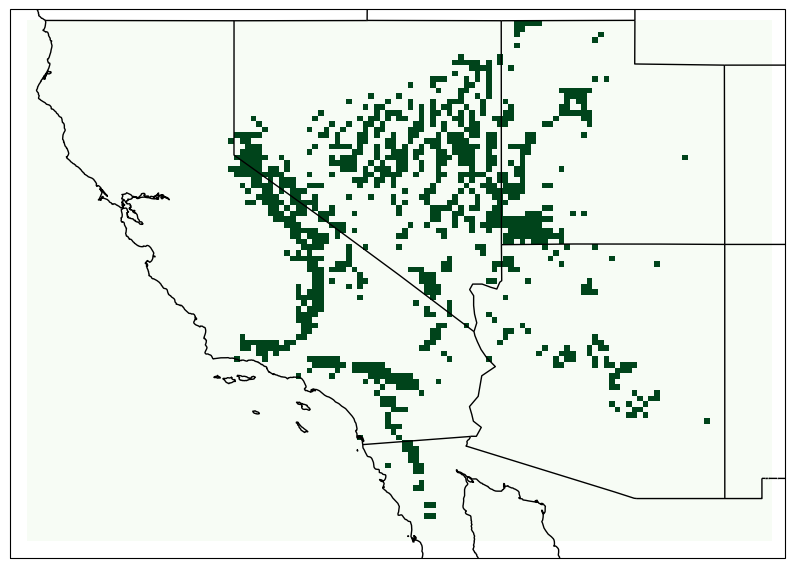

In [571]:
fig,ax=plt.subplots(1,1,sharex=True,sharey=True,figsize=(10,10), dpi = 100,subplot_kw={'projection':ccrs.PlateCarree()})

bounds = [0,0.9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2)
cmap_presence = (colors.ListedColormap(['white','lightgreen']))

plt.pcolormesh(historical['pr']['observation'].longitude,historical['pr']['observation'].latitude,pinyon_grid_presence,cmap = 'Greens')

ax.set_ylim([30,42.25]);
ax.set_xlim([-125,-107.7])
ax.coastlines(linewidth=1)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                            name='admin_1_states_provinces_lines',
                            scale='110m',facecolor='None'),edgecolor='k')


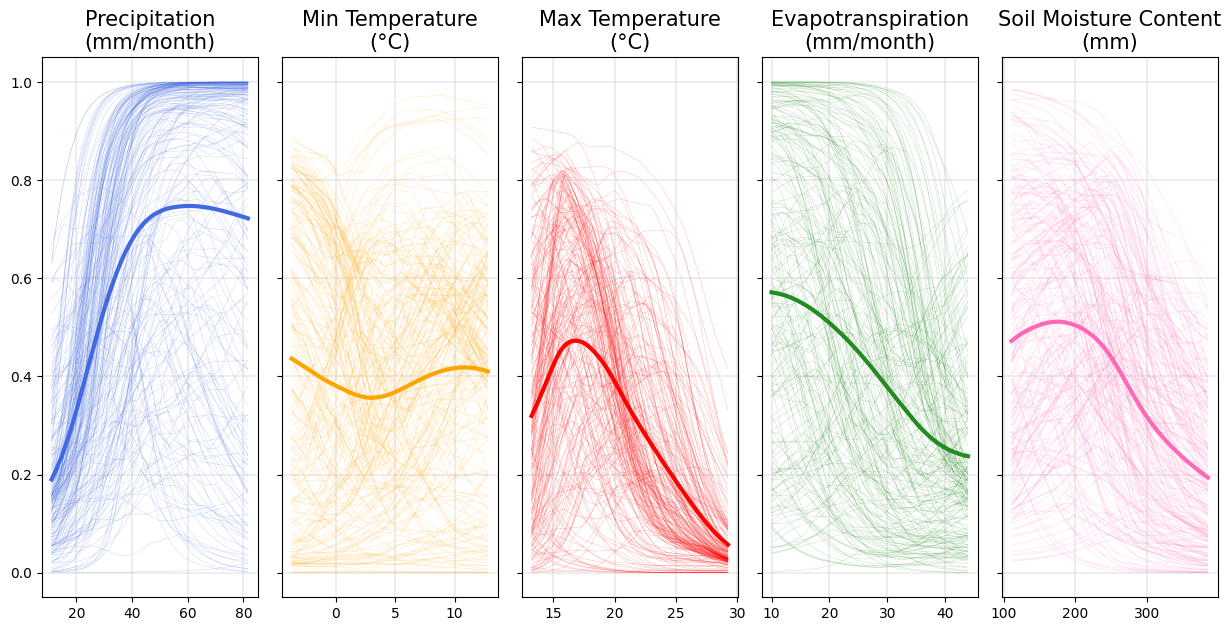

In [617]:
from sklearn.inspection import PartialDependenceDisplay
# X_df = pd.DataFrame(X)
# X_df.columns = variable_list[:-1]

pd_dict = {}
for var in variable_list[:-1]:
    pd_dict[var] = sklearn.inspection.partial_dependence(pipe, X_df, var,percentiles=(0.05,0.95))

ice_dict = {}
for var in variable_list[:-1]:
    ice_dict[var] = sklearn.inspection.partial_dependence(pipe, X_df, var,kind='individual',percentiles=(0.05,0.95))

fig,ax = plt.subplots(1,5,sharey = True, figsize = (12,6))
i = 0
 
color_list = ['royalblue','orange','red','forestgreen','hotpink']

for var in variable_list[:-1]:

    ax[i].plot(pd_dict[var]['values'][0], pd_dict[var]['average'][0], label = var, color = color_list[i],linewidth = 3)
    for j in range(0,len(ice_dict[var]['individual'][0]),10):
        ax[i].plot(ice_dict[var]['values'][0], ice_dict[var]['individual'][0][j], label = var, color = color_list[i], alpha = 0.3, linewidth = 0.3)
    ax[i].set_title(f'{variable_disp_list[i]}\n({unit_list[i]})', fontsize = 15)
    ax[i].set_position([i*0.2,0,0.18,0.9])
    ax[i].grid(linewidth = 0.3)
    
    i += 1
